In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

Dataset Overview:

The dataset used for this project is the Loan Approval Classification Dataset, sourced from Kaggle. It contains  45,000 loan application records, with both numerical and categorical features related to the applicant’s demographics, financial status, and credit history.

The goal is to predict whether a loan application will be approved or rejected.

Modeling Approach

For this experiment, I used Logistic Regression as the type of model to perform binary classification. I scaled the numerical features using StandardScaler and encoded the categorical features appropriately.

The target variable for prediction is:
- loan_status → 1 (approved), 0 (rejected)


In [43]:
loan_data = pd.read_csv("../data/loan_data.csv")

In [44]:
education_map = {'High School': 0, 'Associate': 1, 'Bachelor':2, 'Master':3, 'Doctorate':4}

loan_data['person_education'] = loan_data['person_education'].map(education_map)


hot_enc_cols = ['person_gender', 'person_home_ownership','loan_intent', 'previous_loan_defaults_on_file']
loan_data = pd.get_dummies(loan_data, columns=hot_enc_cols,drop_first=True)


to_fix_col = loan_data.select_dtypes(include='bool').columns
loan_data[to_fix_col] = loan_data[to_fix_col].astype(int)


In [45]:
loan_data.head(5)
loan_data.describe()

,person_age,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status,person_gender_male,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_Yes
count,45000.000000,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,1.383333,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222,0.552022,0.002600,0.065578,0.520956,0.203400,0.106289,0.189956,0.167822,0.173756,0.507956
std,6.045108,1.077741,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744,0.497292,0.050924,0.247545,0.499566,0.402532,0.308210,0.392270,0.373712,0.378903,0.499942
min,20.000000,0.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,1.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,30.000000,2.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,144.000000,4.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Overview of the MIA Pipeline

This notebook implements a modern membership inference attack (MIA) pipeline using:
- Shadow models (we will test on varying # of shadow models)
- Engineered features (confidence, entropy, loss, etc.)
- A single attack model

The goal is to compare attack performance before and after unlearning (retraining without the forget set) specific data.

Data Preparation and Forget Set Definition

Data Split:
- Split the loan dataset into 60% training and 40% test data

Forget Set Selection:
We define a forget set using a percentile threshold over 3 key features with significant weightage:
- High interest rate loans 
- High debt-to-income ratio loans 
- Large loan amounts 

This simulates a real-world scenario where a bank wants to unlearn risky loan patterns from their model due to regulatory changes or fairness concerns. So the forget set contains loan applications that meet at least one high-risk criterion.

In [46]:

#default
config = {'num_shadow_models': 10, 
          'random_seed': 42,
          'forget_percentile': .85}

In [47]:
scaler = StandardScaler()
train_data, test_data = train_test_split(
    loan_data, 
    test_size=0.4, 
    random_state=config['random_seed'], 
    stratify=loan_data['loan_status']
)

rate_threshold = train_data['loan_int_rate'].quantile(config['forget_percentile'])
percent_income_threshold = train_data['loan_percent_income'].quantile(config['forget_percentile'])
loan_amnt_threshold = train_data['loan_amnt'].quantile(config['forget_percentile'])

forget = train_data[
    (train_data['loan_int_rate'] >= rate_threshold) |
    (train_data['loan_percent_income'] >= percent_income_threshold) |
    (train_data['loan_amnt'] >= loan_amnt_threshold)
]

X_forget = forget.drop(columns=['loan_status'])
Y_forget = forget['loan_status']


Target Model Training (Original Model)

Model Configuration:
- Logistic Regression 

Training Process:
1. Use full training data (including forget set)
2. Split into train/test for model validation
3. Apply feature scaling using StandardScaler
4. Train on scaled features


Unlearned Model Training (After Forgetting)

Data Preparation:
- Remove forget set from training data 
- This simulates  unlearning ->forget set never existed

Training Process:
1. Use identical model architecture and hyperparameters\
3. Use separate scaler (unlearn_scaler) to avoid data leakage
4. Train on reduced dataset that excludes forget set

Scaling Forget Set:
- Transform forget set using unlearn_scaler (not original scaler)
- This ensures forget set is processed as the unlearned model would see it

In [48]:
target = LogisticRegression(C=10000, max_iter=10000)

X = train_data.drop('loan_status', axis=1)
Y = train_data['loan_status']

# Original training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=config['random_seed'])
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train, train_size=900, random_state=config['random_seed'], stratify=Y_train
)

X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

target.fit(X_train_scale, Y_train)

# Unlearned model
keep = train_data.drop(forget.index)
X_unlearn = keep.drop('loan_status', axis=1)
Y_unlearn = keep['loan_status']

X_train_unlearn, X_test_unlearn, Y_train_unlearn, Y_test_unlearn = train_test_split(
    X_unlearn, Y_unlearn, test_size=.2, random_state=config['random_seed']
)
X_train_unlearn, X_test_unlearn, Y_train_unlearn, Y_test_unlearn = train_test_split(
    X_train_unlearn, Y_train_unlearn, train_size=900, random_state=config['random_seed'], stratify=Y_train_unlearn
)

unlearn_scaler = StandardScaler()
X_train_unlearn_scale = unlearn_scaler.fit_transform(X_train_unlearn)
X_test_unlearn_scale = unlearn_scaler.transform(X_test_unlearn)

unlearn = LogisticRegression(C=10000, max_iter=10000)
unlearn.fit(X_train_unlearn_scale , Y_train_unlearn)
X_forget_scaled = unlearn_scaler.transform(X_forget)


Number of features: 19
Target model weights (first 10): [ 0.08048616 -0.09726077  0.39195568 -0.32794195 -0.76444051  0.81397171
  1.55979334  0.02241921 -0.63288867  0.00650231]
Unlearn model weights (first 10): [ 0.80060406  0.01684359 -1.56299113 -0.55639114  0.41651034  0.52169814
 -0.13549771 -0.52574239 -0.29848699  0.19207616]

Cosine Similarity: 0.8450

L2 Distance: 0.5420

Weight Difference Statistics:
Mean Absolute Difference: 0.5625
Max Absolute Difference: 1.9549
Number of sign changes: 7/19 features
Percentage of sign changes: 36.8%



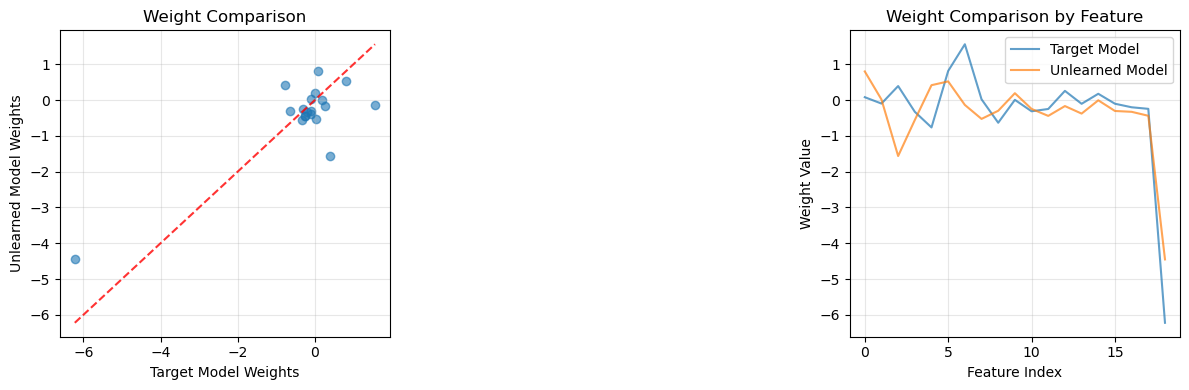

• Cosine Similarity: 0.845 (1.0 = identical, 0.0 = orthogonal)
• Weight Change Magnitude: 0.542 (normalized L2 distance)
• Features with sign flips: 7/19 (36.8%)
• Mean absolute weight change: 0.5625


In [49]:
target_weights = target.coef_[0]  
unlearn_weights = unlearn.coef_[0]

print(f"Number of features: {len(target_weights)}")
print(f"Target model weights (first 10): {target_weights[:10]}")
print(f"Unlearn model weights (first 10): {unlearn_weights[:10]}")
print()

cos_sim = cosine_similarity([target_weights], [unlearn_weights])[0][0]
print(f"Cosine Similarity: {cos_sim:.4f}")
print()
l2_distance = euclidean(target_weights, unlearn_weights)
l2_norm_target = np.linalg.norm(target_weights)
l2_norm_unlearn = np.linalg.norm(unlearn_weights)
normalized_l2 = l2_distance / max(l2_norm_target, l2_norm_unlearn)

print(f"L2 Distance: {normalized_l2:.4f}")
print()
weight_diff = target_weights - unlearn_weights
mean_abs_diff = np.mean(np.abs(weight_diff))
max_abs_diff = np.max(np.abs(weight_diff))
num_sign_changes = np.sum(np.sign(target_weights) != np.sign(unlearn_weights))

print("Weight Difference Statistics:")
print(f"Mean Absolute Difference: {mean_abs_diff:.4f}")
print(f"Max Absolute Difference: {max_abs_diff:.4f}")
print(f"Number of sign changes: {num_sign_changes}/{len(target_weights)} features")
print(f"Percentage of sign changes: {100 * num_sign_changes / len(target_weights):.1f}%")
print()

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(target_weights, unlearn_weights, alpha=0.6)
plt.plot([min(target_weights), max(target_weights)], 
         [min(target_weights), max(target_weights)], 'r--', alpha=0.8)
plt.xlabel('Target Model Weights')
plt.ylabel('Unlearned Model Weights')
plt.title('Weight Comparison')
plt.grid(True, alpha=0.3)


plt.subplot(1, 3, 3)
feature_indices = np.arange(len(target_weights))
plt.plot(feature_indices, target_weights, label='Target Model', alpha=0.7)
plt.plot(feature_indices, unlearn_weights, label='Unlearned Model', alpha=0.7)
plt.xlabel('Feature Index')
plt.ylabel('Weight Value')
plt.title('Weight Comparison by Feature')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f"• Cosine Similarity: {cos_sim:.3f} (1.0 = identical, 0.0 = orthogonal)")
print(f"• Weight Change Magnitude: {normalized_l2:.3f} (normalized L2 distance)")
print(f"• Features with sign flips: {num_sign_changes}/{len(target_weights)} ({100 * num_sign_changes / len(target_weights):.1f}%)")
print(f"• Mean absolute weight change: {mean_abs_diff:.4f}")

Purpose: simply a check for myself to make sure model weights have shifted due to unlearning

Model Similarity
Cosine Similarity = 0.8450
-Measures directional similarity between weight vectors
   - 1.0 = identical models, 0.0 = orthogonal models    
- Indicates moderate similarity between the target model and unlearned model.


Magnitude of Change
L2 Distance = 0.5420
- quantifies the similarity or dissimilarity between data points
- L2 distance > 0.5 suggests substantial changes in model weights.

Max Absolute Difference = 1.9549
→ At least one feature had a very large change, pointing to targeted impact of unlearning.

Sign Flips
7 out of 19 weights changed sign (≈ 36.8%)
- A sign flip indicates a qualitative change in how the feature influences the prediction.
- Nearly 40% sign changes suggest that unlearning significantly altered decision boundaries.

Shadow Model Setup for Membership Inference Attack

Purpose: Create  models to generate labeled training data for our membership inference attack.

Data Partitioning Strategy:
1. Split into equal chunks - one chunk per shadow model
2. Each chunk split 50/50 into shadow_train and shadow_test sets

- Each shadow model gets completely disjoint training data (according to Shokri paper)
- We know exactly which samples each shadow model has "seen" (members) vs "not seen" (non-members)
- This creates the labels needed to train our attack model

Shadow Model Training

Training Process:
For each shadow model:
1. Separate scaler - prevents information leakage between shadow models
2. Identical architecture - same LogisticRegression(C=10000) as target models
3. Feature scaling - standardize inputs for stable training


Output:
- N trained shadow models with known member/non-member distinctions
- Scaled training data and scalers for consistent training

In [50]:
num_shadow_models = config['num_shadow_models']
chunks = int(len(test_data) / num_shadow_models)
shuffled_df = test_data.sample(frac=1, random_state=config['random_seed']).reset_index(drop=True)
shadow_sets = []

for num in range(num_shadow_models):
    start_index = int(chunks * num)
    end_index = int(start_index + chunks)
    shadow_train, shadow_test = train_test_split(shuffled_df[start_index:end_index], test_size=.5, random_state=config['random_seed'])
    shadow_sets.append((shadow_train, shadow_test))

shadow_models = []
shadow_scaled_data = []
shadow_scalers = []

for num in range(num_shadow_models):
    shadow_scaler = StandardScaler()
    shadow_train = shadow_sets[num][0]
    X_shadow_train = shadow_train.drop('loan_status', axis=1)
    Y_shadow_train = shadow_train['loan_status']
    X_shadow_train_scaled = shadow_scaler.fit_transform(X_shadow_train)
    model = LogisticRegression(C=10000, max_iter=10000)
    model.fit(X_shadow_train_scaled, Y_shadow_train)

    shadow_models.append(model)
    shadow_scalers.append(shadow_scaler)
    shadow_scaled_data.append((X_shadow_train_scaled, Y_shadow_train))


Attack Feature Engineering

Purpose: Extract confidence-based features that reveal membership patterns from shadow models.
#send papers that use engieneered features
Feature Extraction Function:
- Input: Shadow models, their scalers, and datasets
- Output: Engineered features that capture membership signals

Engineered Features (4 per a data point):
1. Max Confidence: Highest probability across all classes - measures model certainty
2. Entropy: Uncertainty measure - lower entropy indicates higher confidence
3. True Class Probability: Model's confidence in the correct label
4. Loss: Negative log-likelihood - higher loss indicates model struggled with prediction

Generate Attack Training Dataset

Member Samples (Label = 1):
- Extract features from each shadow model's training data
- These are samples the shadow model has seen during training

Non-Member Samples (Label = 0):
- Extract features from each shadow model's held-out test data
- These are samples the shadow model has never seen

Result:
- Balanced dataset: Equal numbers of member (1) and non-member (0) samples
- Rich feature representation: 4 confidence-based features per sample

This creates the supervised learning : Given confidence features, predict if a sample was in the training set.

In [51]:
def extract_attack_features(models, scalers, datasets, member=True):
    features, labels = [], []
    label_value = 1 if member else 0

    for i in range(len(models)):
        model = models[i]
        scaler = scalers[i]
        if member:
            X_data_scaled, Y_data = datasets[i]
        else:
            test_df = shadow_sets[i][1]
            X_data = test_df.drop('loan_status', axis=1)
            Y_data = test_df['loan_status']
            X_data_scaled = scaler.transform(X_data)

        preds = model.predict(X_data_scaled)
        probs = model.predict_proba(X_data_scaled)
        max_conf = np.max(probs, axis=1)
        entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
        true_class_proba = probs[np.arange(len(Y_data)), Y_data]
        loss = -np.log(true_class_proba + 1e-8)

        attack_feat = np.column_stack([max_conf, entropy, true_class_proba, loss])
        features.append(attack_feat)
        labels.append(np.full(len(attack_feat), label_value))

    return np.vstack(features), np.hstack(labels)

member_feature, member_label = extract_attack_features(shadow_models, shadow_scalers, shadow_scaled_data, member=True)
non_member_feature, non_member_label = extract_attack_features(shadow_models, shadow_scalers, shadow_scaled_data, member=False)


Attack Model Training

Dataset Preparation:
- Combine member and non-member features 
- Merge corresponding labels (1s for members, 0s for non-members)
- Result:  binary classification dataset

Attack Model:
- Logistic Regression
- Purpose: Learn to distinguish member vs non-member confidence patterns
- Input: 4 standardized confidence features per sample
- Output: Probability that a sample was in the training set

Result: Trained attack model that can predict membership status given confidence features from any target model.

In [52]:
X_attack = np.vstack([member_feature, non_member_feature])
y_attack = np.hstack([member_label, non_member_label])
attack_scaler = StandardScaler()
X_attack_scale = attack_scaler.fit_transform(X_attack)

attack = LogisticRegression(max_iter=1000)
attack.fit(X_attack_scale, y_attack)


LogisticRegression(max_iter=1000)

Evaluation on Target Models

Feature Extraction for Evaluation:
- Extract the same 4 engineered features from both target and unlearned models
- Input: Forget set data 
- Output: Confidence features for attack model evaluation

Attack:
1. Target Model: Extract features from model that saw the forget set during training
2. Unlearned Model: Extract features from model that never saw the forget set
3. Scale features using the same scaler fitted on attack training data
4. Apply attack model to predict membership for each sample

Expected Attack Behavior:
- Target Model Predictions: High attack accuracy (~80%+) 
 - Attack correctly identifies forget set as "members" (model has seen this data)
- Unlearned Model Predictions:** Lower attack accuracy (~50-60%)
 - Attack struggles to identify forget set as "members" (model never saw this data)

Privacy Gain Calculation

Evaluation Strategy:
- Ground Truth: All forget set samples are "members" (label = 1) for target model
- Attack Success: Measures how well attack model detects membership

Key Metrics:
- Target Accuracy: How often attack correctly identifies forget set as members in original model
- Unlearn Accuracy: How often attack identifies forget set as members in unlearned model  
- Privacy Gain= target_accuracy - unlearn_accuracy

Interpretation:
- High Privacy Gain (>20%): Unlearning successfully reduced membership leakage
- Low Privacy Gain (<5%): Unlearning was ineffective
- Negative Privacy Gain: Unlearning made things worse (shouldn't happen)

Expected Result: ~25% privacy gain, meaning unlearning reduced membership inference accuracy by 25 percentage points.

Something that would be intersitng to look into is what anna said last time about adding noise after unlearning (differential privacy) and see what happens.

In [53]:
def get_attack_features(model, X_scaled, Y_true):
    probs = model.predict_proba(X_scaled)
    preds = model.predict(X_scaled)
    max_conf = np.max(probs, axis=1)
    entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
    true_class_proba = probs[np.arange(len(Y_true)), Y_true]
    loss = -np.log(true_class_proba + 1e-8)
    return np.column_stack([max_conf, entropy, true_class_proba, loss])

target_attack_features = get_attack_features(target, X_forget_scaled, Y_forget)
unlearn_attack_features = get_attack_features(unlearn, X_forget_scaled, Y_forget)

target_attack_scaled = attack_scaler.transform(target_attack_features)
unlearn_attack_scaled = attack_scaler.transform(unlearn_attack_features)

target_preds = attack.predict(target_attack_scaled)
unlearn_preds = attack.predict(unlearn_attack_scaled)

target_acc = accuracy_score(np.ones(len(target_preds)), target_preds)
unlearn_acc = accuracy_score(np.ones(len(unlearn_preds)), unlearn_preds)


In [54]:
attack_model = attack
attack_scaler= attack_scaler
target_model=target
unlearned_model = unlearn
target_attack_features_scaled=target_attack_scaled,
forget_set= forget
target_accuracy =target_acc
unlearn_accuracy=unlearn_acc

In [55]:
def calculate_model_metrics(model, X_scaled, y_true, model_name):
    
    predictions = model.predict(X_scaled)
    probabilities = model.predict_proba(X_scaled)[:, 1]  
    
    metrics = {
        f'{model_name}_accuracy': accuracy_score(y_true, predictions),
        f'{model_name}_f1': f1_score(y_true, predictions),
        f'{model_name}_auc': roc_auc_score(y_true, probabilities)
    }
    
    return metrics

Below is the pipeline (all of the code condensed into a single function) to perform further analysis. 

In [56]:
#original standalone
def run_pipeline(config):
    scaler = StandardScaler()


    train_data, test_data = train_test_split(loan_data, test_size=0.4, random_state=config['random_seed'], stratify=loan_data['loan_status'])


    rate_threshold = train_data['loan_int_rate'].quantile(config['forget_percentile'])
    percent_income_threshold = train_data['loan_percent_income'].quantile(config['forget_percentile'])
    loan_amnt_threshold = train_data['loan_amnt'].quantile(config['forget_percentile'])


    forget = train_data[(train_data['loan_int_rate'] >= rate_threshold) |
                (train_data['loan_percent_income'] >= percent_income_threshold) |
                (train_data['loan_amnt'] >= loan_amnt_threshold)]


    X_forget = forget.drop(columns=['loan_status'])
    Y_forget = forget['loan_status']
    len(forget)


    target = LogisticRegression(C=10000, max_iter=10000)


    X = train_data.drop('loan_status', axis=1)
    Y =train_data['loan_status']


    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=config['random_seed'])


    X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train,
    train_size=900,  
    random_state=config['random_seed'],
    stratify=Y_train
    )
    X_train_scale = scaler.fit_transform(X_train)
    X_test_scale = scaler.transform(X_test)


    target.fit(X_train_scale, Y_train)
    unlearn_scaler = StandardScaler()
    keep = train_data.drop(forget.index)




    unlearn = LogisticRegression(C=10000, max_iter=10000)


    X_unlearn = keep.drop('loan_status', axis=1)
    Y_unlearn =keep['loan_status']




    X_train_unlearn, X_test_unlearn, Y_train_unlearn, Y_test_unlearn = train_test_split(X_unlearn, Y_unlearn, test_size=.2, random_state=config['random_seed'])


    X_train_unlearn, X_test_unlearn, Y_train_unlearn, Y_test_unlearn = train_test_split(
    X_train_unlearn, Y_train_unlearn,
    train_size=900,
    random_state=config['random_seed'],
    stratify=Y_train_unlearn
    )


    X_train_unlearn_scale = unlearn_scaler.fit_transform(X_train_unlearn)
    X_test_unlearn_scale = unlearn_scaler.transform(X_test_unlearn)


    unlearn.fit(X_train_unlearn_scale , Y_train_unlearn)
    X_forget_scaled = unlearn_scaler.transform(X_forget)



    predictions = target.predict(X_forget_scaled)
    predictions_unlearn = unlearn.predict(X_forget_scaled)




    num_shadow_models = config['num_shadow_models']
    chunks = int(len(test_data)/num_shadow_models)
    shuffled_df = test_data.sample(frac=1, random_state=config['random_seed']).reset_index(drop=True)
    shadow_sets = []


    for num in range(num_shadow_models):
        start_index = int(chunks*num)
        end_index = int(start_index+chunks)


        shadow_train, shadow_test = train_test_split(shuffled_df[start_index:end_index], test_size=.5, random_state=config['random_seed'])
        shadow_sets.append((shadow_train, shadow_test))


    shadow_models = []
    shadow_scaled_data = []
    shadow_scalers =[]
    for num in range(num_shadow_models):
        shadow_scaler = StandardScaler()
        
        shadow_train = shadow_sets[num][0]
        X_shadow_train = shadow_train.drop('loan_status', axis=1)
        Y_shadow_train = shadow_train['loan_status']


        X_shadow_train_scaled = shadow_scaler.fit_transform(X_shadow_train)



        i = LogisticRegression(C=10000,max_iter=10000)
        i.fit(X_shadow_train_scaled, Y_shadow_train )


        shadow_scalers.append(shadow_scaler)
        shadow_scaled_data.append((X_shadow_train_scaled,Y_shadow_train))
        shadow_models.append((i))
        
    member_feature= []
    member_label = []


    for num in range(num_shadow_models):


        model = shadow_models[num]
        scaled_data = shadow_scaled_data[num][0]
        Y_data = shadow_scaled_data[num][1]


        results = model.predict_proba(scaled_data)




        max_confidence = np.max(results, axis=1)
        entropy = -np.sum(results * np.log(results + 1e-8), axis=1)
        predictions = model.predict(scaled_data)
        true_class_proba = results[np.arange(len(Y_data)), Y_data]
        correctness = (predictions == Y_data).astype(int)
        loss = -np.log(true_class_proba + 1e-8)
        vectors = calculate_model_metrics(model, scaled_data, Y_data, num)
      


        attack_features = np.column_stack([
            max_confidence,
            entropy,
            true_class_proba,
            loss
        ])
        member_feature.append(attack_features)
        member_label.append(np.ones(len(attack_features)))


    non_member_feature= []
    non_member_label = []


    for num in range(num_shadow_models):


        model = shadow_models[num]
        test_set = shadow_sets[num][1]
        scaler = shadow_scalers[num]


        X_test = test_set.drop('loan_status', axis=1)
        Y_data_test = test_set['loan_status']
        X_test_scaled = scaler.transform(X_test)


        results = model.predict_proba(X_test_scaled)






        max_confidence = np.max(results, axis=1)
        entropy = -np.sum(results * np.log(results + 1e-8), axis=1)
        predictions = model.predict(X_test_scaled)
        true_class_proba = results[np.arange(len(Y_data_test)), Y_data_test]
        correctness = (predictions == Y_data_test).astype(int)
        loss = -np.log(true_class_proba + 1e-8)


        vectors = calculate_model_metrics(model, X_test_scaled, Y_data_test, num)
      


        attack_features = np.column_stack([
            max_confidence,
            entropy,
            true_class_proba,
            loss
        ])
        #print(attack_features)
        non_member_feature.append(attack_features)
        non_member_label.append(np.zeros(len(attack_features)))




    X_attack = np.vstack(member_feature + non_member_feature)
    y_attack = np.hstack(member_label + non_member_label)
    attack_scaler = StandardScaler()


    X_attack_scale = attack_scaler.fit_transform(X_attack)


    attack = LogisticRegression(max_iter=1000)
    attack.fit(X_attack_scale, y_attack)
    target_results = target.predict_proba(X_forget_scaled)

    max_confidence = np.max(target_results, axis=1)
    entropy = -np.sum(target_results * np.log(target_results + 1e-8), axis=1)
    target_predictions = target.predict(X_forget_scaled)
    true_class_proba = target_results[np.arange(len(Y_forget)), Y_forget]
    correctness = (target_predictions == Y_forget).astype(int)
    loss = -np.log(true_class_proba + 1e-8)


    target_attack_features = np.column_stack([
        max_confidence,
        entropy,
        true_class_proba,
        loss
    ])


    target_attack_features_scaled = attack_scaler.transform(target_attack_features)
    unlearn_results = unlearn.predict_proba(X_forget_scaled)


    max_confidence = np.max(unlearn_results, axis=1)
    entropy = -np.sum(unlearn_results * np.log(unlearn_results + 1e-8), axis=1)
    unlearn_predictions = unlearn.predict(X_forget_scaled)
    true_class_proba = unlearn_results[np.arange(len(Y_forget)), Y_forget]
    correctness = (unlearn_predictions == Y_forget).astype(int)
    loss = -np.log(true_class_proba + 1e-8)


    unlearn_attack_features = np.column_stack([
        max_confidence,
        entropy,
        true_class_proba,
        loss
    ])


    unlearn_attack_features_scaled = attack_scaler.transform(unlearn_attack_features)
    target_attack_predictions = attack.predict(target_attack_features_scaled)
    target_attack_accuracy = accuracy_score(np.ones(len(target_attack_predictions)), target_attack_predictions)
    unlearn_attack_predictions = attack.predict(unlearn_attack_features_scaled)
    unlearn_attack_accuracy = accuracy_score(np.ones(len(unlearn_attack_predictions)), unlearn_attack_predictions) 


    retain_metrics_original = calculate_model_metrics(target, scaler.transform(X_test_scale), Y_test, 'original_retain')
    retain_metrics_unlearned = calculate_model_metrics(unlearn, X_test_unlearn_scale, Y_test_unlearn, 'unlearned_retain')
    forget_metrics_original = calculate_model_metrics(target, scaler.transform(X_forget), Y_forget, 'original_forget')
    forget_metrics_unlearned = calculate_model_metrics(unlearn, X_forget_scaled, Y_forget, 'unlearned_forget')
    

    unlearn_attack_features_scaled = attack_scaler.transform(unlearn_attack_features)
    target_attack_predictions = attack.predict(target_attack_features_scaled)
    target_attack_accuracy = accuracy_score(np.ones(len(target_attack_predictions)), target_attack_predictions)
    unlearn_attack_predictions = attack.predict(unlearn_attack_features_scaled)
    unlearn_attack_accuracy = accuracy_score(np.ones(len(unlearn_attack_predictions)), unlearn_attack_predictions)
    
    
    return {
        'attack_model': attack,
        'attack_scaler': attack_scaler,
        'target_model': target,
        'unlearned_model': unlearn,
        'target_attack_features_scaled': target_attack_features_scaled,
        'forget_set': forget,
        'target_accuracy':target_attack_accuracy,
        'unlearn_accuracy':unlearn_attack_accuracy,
        'retain_metrics_original': retain_metrics_original,
        'retain_metrics_unlearned': retain_metrics_unlearned,
        'forget_metrics_original': forget_metrics_original,
        'forget_metrics_unlearned': forget_metrics_unlearned
    }


Max Confidence Only:
  Target Accuracy: 0.782
  Unlearn Accuracy: 0.432
  Privacy Gain: 0.350

Entropy Only:
  Target Accuracy: 0.713
  Unlearn Accuracy: 0.401
  Privacy Gain: 0.312

True Class Prob Only:
  Target Accuracy: 0.747
  Unlearn Accuracy: 0.436
  Privacy Gain: 0.312

Loss Only:
  Target Accuracy: 0.778
  Unlearn Accuracy: 0.485
  Privacy Gain: 0.293

Max Confidence + Entropy:
  Target Accuracy: 0.743
  Unlearn Accuracy: 0.413
  Privacy Gain: 0.331

Max Confidence + True Class Prob:
  Target Accuracy: 0.849
  Unlearn Accuracy: 0.751
  Privacy Gain: 0.097

Max Confidence + Loss:
  Target Accuracy: 0.830
  Unlearn Accuracy: 0.657
  Privacy Gain: 0.172

Entropy + True Class Prob:
  Target Accuracy: 0.822
  Unlearn Accuracy: 0.630
  Privacy Gain: 0.193

Entropy + Loss:
  Target Accuracy: 0.825
  Unlearn Accuracy: 0.642
  Privacy Gain: 0.183

True Class Prob + Loss:
  Target Accuracy: 0.842
  Unlearn Accuracy: 0.719
  Privacy Gain: 0.123

============================== THREE-FEAT

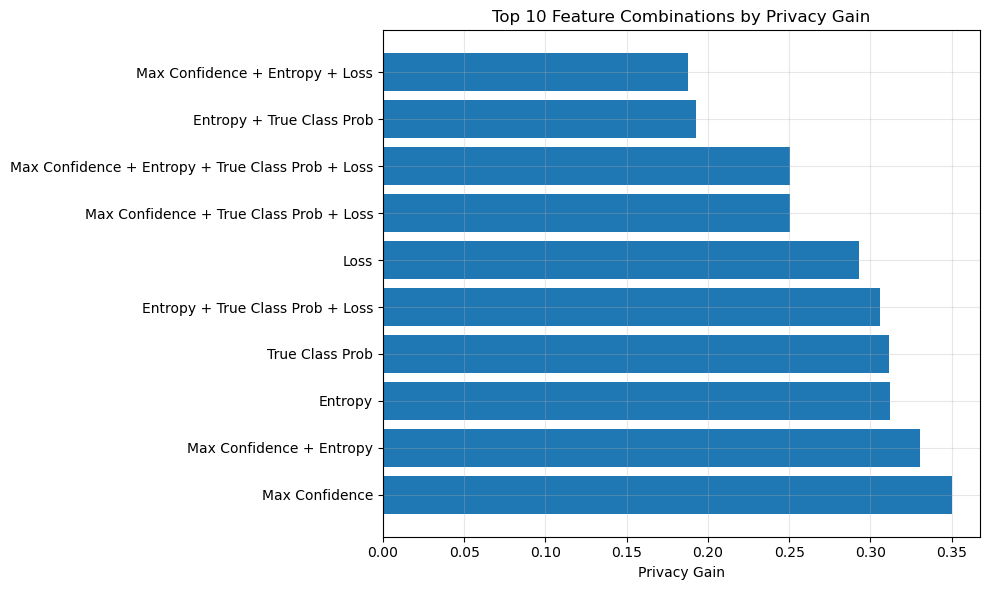

In [57]:
def test_feature_combination(member_features, non_member_features, feature_indices, feature_names):
    

    X_member = member_features[:, feature_indices]
    X_non_member = non_member_features[:, feature_indices]
    

    X_attack = np.vstack([X_member, X_non_member])
    y_attack = np.hstack([np.ones(len(X_member)), np.zeros(len(X_non_member))])
    
    scaler = StandardScaler()
    X_attack_scaled = scaler.fit_transform(X_attack)
    
    attack_model = LogisticRegression(max_iter=1000, random_state=42)
    attack_model.fit(X_attack_scaled, y_attack)
    
    target_features = get_attack_features(target, X_forget_scaled, Y_forget)[:, feature_indices]
    unlearn_features = get_attack_features(unlearn, X_forget_scaled, Y_forget)[:, feature_indices]
    
    target_scaled = scaler.transform(target_features)
    unlearn_scaled = scaler.transform(unlearn_features)
    
    target_preds = attack_model.predict(target_scaled)
    unlearn_preds = attack_model.predict(unlearn_scaled)
    
    target_acc = accuracy_score(np.ones(len(target_preds)), target_preds)
    unlearn_acc = accuracy_score(np.ones(len(unlearn_preds)), unlearn_preds)
    privacy_gain = target_acc - unlearn_acc
    
    return {
        'features': feature_names,
        'target_accuracy': target_acc,
        'unlearn_accuracy': unlearn_acc,
        'privacy_gain': privacy_gain,
        'attack_model': attack_model,
        'scaler': scaler
    }



feature_names = ['Max Confidence', 'Entropy', 'True Class Prob', 'Loss']

#  individual features tested
results = []
for i, name in enumerate(feature_names):
    result = test_feature_combination(member_feature, non_member_feature, [i], [name])
    results.append(result)
    print(f"\n{name} Only:")
    print(f"  Target Accuracy: {result['target_accuracy']:.3f}")
    print(f"  Unlearn Accuracy: {result['unlearn_accuracy']:.3f}")
    print(f"  Privacy Gain: {result['privacy_gain']:.3f}")

pair_combinations = [
    ([0, 1], ['Max Confidence', 'Entropy']),
    ([0, 2], ['Max Confidence', 'True Class Prob']),
    ([0, 3], ['Max Confidence', 'Loss']),
    ([1, 2], ['Entropy', 'True Class Prob']),
    ([1, 3], ['Entropy', 'Loss']),
    ([2, 3], ['True Class Prob', 'Loss'])
]

for indices, names in pair_combinations:
    result = test_feature_combination(member_feature, non_member_feature, indices, names)
    results.append(result)
    print(f"\n{' + '.join(names)}:")
    print(f"  Target Accuracy: {result['target_accuracy']:.3f}")
    print(f"  Unlearn Accuracy: {result['unlearn_accuracy']:.3f}")
    print(f"  Privacy Gain: {result['privacy_gain']:.3f}")

print(f"\n{'='*30} THREE-FEATURE COMBINATIONS {'='*30}")
three_combinations = [
    ([0, 1, 2], ['Max Confidence', 'Entropy', 'True Class Prob']),
    ([0, 1, 3], ['Max Confidence', 'Entropy', 'Loss']),
    ([0, 2, 3], ['Max Confidence', 'True Class Prob', 'Loss']),
    ([1, 2, 3], ['Entropy', 'True Class Prob', 'Loss'])
]

for indices, names in three_combinations:
    result = test_feature_combination(member_feature, non_member_feature, indices, names)
    results.append(result)
    print(f"\n{' + '.join(names)}:")
    print(f"  Target Accuracy: {result['target_accuracy']:.3f}")
    print(f"  Unlearn Accuracy: {result['unlearn_accuracy']:.3f}")
    print(f"  Privacy Gain: {result['privacy_gain']:.3f}")

print(f"\n{'='*30} ALL FEATURES COMBINED {'='*30}")
all_result = test_feature_combination(member_feature, non_member_feature, [0, 1, 2, 3], feature_names)
results.append(all_result)
print(f"\nAll Features Combined:")
print(f"  Target Accuracy: {all_result['target_accuracy']:.3f}")
print(f"  Unlearn Accuracy: {all_result['unlearn_accuracy']:.3f}")
print(f"  Privacy Gain: {all_result['privacy_gain']:.3f}")

summary_data = []
for result in results:
    summary_data.append({
        'Feature Combination': ' + '.join(result['features']),
        'Target Acc': result['target_accuracy'],
        'Unlearn Acc': result['unlearn_accuracy'],
        'Privacy Gain': result['privacy_gain'],
        'Num Features': len(result['features'])
    })

df_results = pd.DataFrame(summary_data)
df_results = df_results.sort_values('Privacy Gain', ascending=False)

print(f"\n{'='*60}")
print("RANKED RESULTS (by Privacy Gain):")
print("="*60)
print(df_results.round(3).to_string(index=False))

plt.figure(figsize=(10, 6))
top_10 = df_results.head(10)
plt.barh(range(len(top_10)), top_10['Privacy Gain'])
plt.yticks(range(len(top_10)), top_10['Feature Combination'], fontsize=10)
plt.xlabel('Privacy Gain')
plt.title('Top 10 Feature Combinations by Privacy Gain')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

best_single = df_results[df_results['Num Features'] == 1].iloc[0]
best_overall = df_results.iloc[0]
all_features = df_results[df_results['Num Features'] == 4].iloc[0]


improvement_over_best_single = best_overall['Privacy Gain'] - best_single['Privacy Gain']
improvement_over_all = best_overall['Privacy Gain'] - all_features['Privacy Gain']


top_5 = df_results.head(5)
feature_counts = {name: 0 for name in feature_names}

for _, row in top_5.iterrows():
    for feature in feature_names:
        if feature in row['Feature Combination']:
            feature_counts[feature] += 1


In [58]:
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")


scenarios = [
    { 'random_seed':42, 'num_shadow_models':10, 'forget_percentile': 0.85},
    { 'random_seed':42, 'num_shadow_models':10, 'forget_percentile': 0.87},
    { 'random_seed':42, 'num_shadow_models':10, 'forget_percentile': 0.89},
    { 'random_seed':42, 'num_shadow_models':10, 'forget_percentile': 0.91},
    { 'random_seed':42, 'num_shadow_models':10, 'forget_percentile': 0.93},
    { 'random_seed':42, 'num_shadow_models':10, 'forget_percentile': 0.95},
    { 'random_seed':42, 'num_shadow_models':10, 'forget_percentile': 0.97}
]

all_results = []

for scenario in scenarios:
    results = run_pipeline(scenario)
    all_results.append({
        'percentile': f"{scenario['forget_percentile']*100:.0f}th",
        'forget_size': len(results['forget_set']),
        'original_attack': f"{results['target_accuracy']*100:.1f}%",
        'unlearned_attack': f"{results['unlearn_accuracy']*100:.1f}%",
        'improvement': f"{(results['target_accuracy'] - results['unlearn_accuracy']) * 100:.1f}%"
    })

df = pd.DataFrame(all_results)
print(df)


  percentile  forget_size original_attack unlearned_attack improvement
0       85th         9362           80.3%            55.3%       25.1%
1       87th         8368           81.2%            57.7%       23.5%
2       89th         7243           81.9%            66.8%       15.0%
3       91th         6244           82.3%            66.9%       15.3%
4       93th         5387           81.2%            76.7%        4.5%
5       95th         3635           80.2%            74.6%        5.6%
6       97th         2400           78.6%            77.0%        1.6%


In [59]:
scenarios = [
    {'random_seed': 42, 'forget_percentile': 0.85, 'num_shadow_models': 10},
    { 'random_seed': 42,'forget_percentile': 0.90,'num_shadow_models': 10 },
    {'random_seed': 42,'forget_percentile': 0.95, 'num_shadow_models': 10}
]

all_results = []

for scenario in scenarios:
    results = run_pipeline(scenario)
    all_results.append({
    'percentile': f"{scenario['forget_percentile']*100:.0f}th",
    #'forget_size': len(results['forget_set']),
    'original_attack': f"{results['target_accuracy']*100:.1f}%",
    'unlearned_attack': f"{results['unlearn_accuracy']*100:.1f}%",
    'improvement': f"{(results['target_accuracy']-results['unlearn_accuracy'])*100:.1f}%",


    'retain_auc_original': f"{results['retain_metrics_original']['original_retain_auc']*100:.1f}%",


    'retain_auc_unlearned': f"{results['retain_metrics_unlearned']['unlearned_retain_auc']*100:.1f}%",
    

    'forget_accuracy_original': f"{results['forget_metrics_original']['original_forget_accuracy']*100:.1f}%",
    'forget_f1_original': f"{results['forget_metrics_original']['original_forget_f1']*100:.1f}%",
    'forget_accuracy_unlearned': f"{results['forget_metrics_unlearned']['unlearned_forget_accuracy']*100:.1f}%",
    'forget_f1_unlearned': f"{results['forget_metrics_unlearned']['unlearned_forget_f1']*100:.1f}%",

})

df = pd.DataFrame(all_results)
print(df)

  percentile original_attack unlearned_attack improvement retain_auc_original  \
0       85th           80.3%            55.3%       25.1%               86.6%   
1       90th           82.3%            61.8%       20.5%               86.6%   
2       95th           80.2%            74.6%        5.6%               86.6%   

  retain_auc_unlearned forget_accuracy_original forget_f1_original  \
0                91.2%                    83.9%              81.2%   
1                92.1%                    84.0%              84.0%   
2                93.9%                    84.8%              86.1%   

  forget_accuracy_unlearned forget_f1_unlearned  
0                     75.0%               66.0%  
1                     73.4%               69.8%  
2                     85.1%               86.2%  


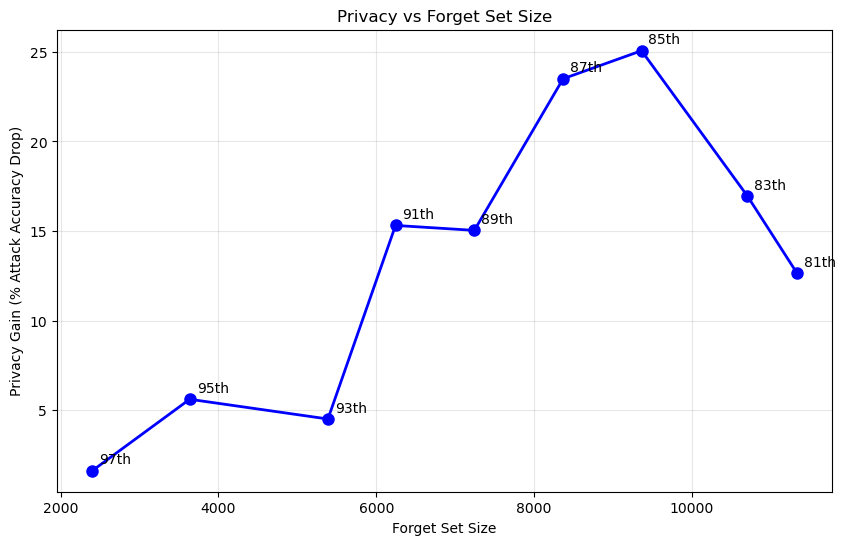

In [60]:
def analyze_forget_set_effects():
    percentiles = [ .81,.83,0.85, 0.87, 0.89, 0.91, 0.93, 0.95, 0.97]
    results = []
        
    for p in percentiles:
        config = {
                'forget_percentile': p,
                'random_seed': 42, 
                'num_shadow_models': 10,
                'training_size': 900
            }
            
        result = run_pipeline(config)
            
        results.append({
                'percentile': f"{p*100:.0f}th",
                'forget_size': len(result['forget_set']),
                'privacy_gain': (result['target_accuracy'] - result['unlearn_accuracy']) * 100,
                'target_acc': result['target_accuracy'] * 100,
                'unlearn_acc': result['unlearn_accuracy'] * 100
        })
        
    return results

results = analyze_forget_set_effects()

forget_sizes = [r['forget_size'] for r in results]
privacy_gains = [r['privacy_gain'] for r in results]
percentiles = [r['percentile'] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(forget_sizes, privacy_gains, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Forget Set Size')
plt.ylabel('Privacy Gain (% Attack Accuracy Drop)')
plt.title('Privacy vs Forget Set Size')
plt.grid(True, alpha=0.3)

for i, (x, y, label) in enumerate(zip(forget_sizes, privacy_gains, percentiles)):
    plt.annotate(label, (x, y), xytext=(5, 5), textcoords='offset points')

plt.show()

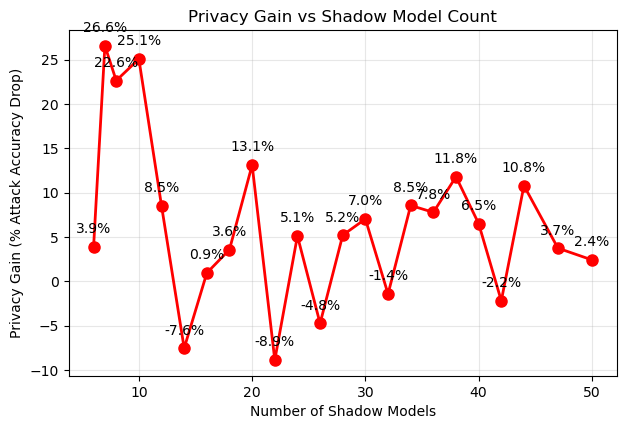

In [61]:
def analyze_shadow_model_effects():
    shadow_counts = [6, 7, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 47, 50]
    results = []
    
    for n_shadows in shadow_counts:
        config = {
            'forget_percentile': 0.85, 
            'random_seed': 42,
            'num_shadow_models': n_shadows,
            'training_size': 900
        }
        
        result = run_pipeline(config)
      
        
        results.append({
            'n_shadow_models': n_shadows,
            'forget_size': len(result['forget_set']),
            'privacy_gain': (result['target_accuracy'] - result['unlearn_accuracy']) * 100,
            'target_acc': result['target_accuracy'] * 100,
            'unlearn_acc': result['unlearn_accuracy'] * 100,
            'non_member_detection': (1 - result['unlearn_accuracy']) * 100,
         
        })
    
    return results

shadow_results = analyze_shadow_model_effects()

shadow_counts = [r['n_shadow_models'] for r in shadow_results]
privacy_gains = [r['privacy_gain'] for r in shadow_results]
target_accs = [r['target_acc'] for r in shadow_results]
unlearn_accs = [r['unlearn_acc'] for r in shadow_results]

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(shadow_counts, privacy_gains, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Shadow Models')
plt.ylabel('Privacy Gain (% Attack Accuracy Drop)')
plt.title('Privacy Gain vs Shadow Model Count')
plt.grid(True, alpha=0.3)

for x, y in zip(shadow_counts, privacy_gains):
    plt.annotate(f'{y:.1f}%', (x, y), xytext=(0, 10), textcoords='offset points', ha='center')


plt.tight_layout()
plt.show()


Limited evaluation on different data types/models
No standardized benchmarks for "how unlearned is unlearned enough?"
What's the privacy-utility tradeoff curve?

Thoughts for larger experiment:
Defining Sufficient Unlearning for MIA

Approach 1: Privacy Gain Threshold
- Sufficient if Privacy Gain ≥ 20%
- Rationale: Substantial reduction in membership detectability
- reader can judge if it suits their purposes

Approach 2: Attack Accuracy Threshold
- Sufficient if Unlearn Attack Accuracy ≤ 60%
- Rationale: Close to random guessing (50%). If attack accuracy = 50%, the model leaks NO membership information. This is the  minimum for binary classification
- 
Approach 3: Random Guessing Baseline
- Sufficient if within 10% of random (50% ± 10%)